In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install nltk
pip install Distance

In [ ]:
from distance import jaccard
from nltk.metrics.distance import edit_distance, jaro_winkler_similarity

In [31]:
X = []
y = []

path = ""

# calcoliamo le features di ogni timeseries

with open(path + 'ThingspeakEU.meta.csv', 'r', encoding='utf-8') as dati:
    for row in dati:
        riga = row.strip().split(',')
        classe = int(riga[8])
        y.append(classe)
        valore = riga[1]
        X.append(valore)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [85]:
# calcolo distanza damerau-levenshtein

def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition

    return d[lenstr1-1,lenstr2-1]

In [84]:
# semplice 1NN classifier - inverse è True se la distance_metric è una similarity metric

def predict_labels(X_train, y_train, X_test, distance_metric, inverse = False):
    y_predict = []

    for i in range(len(X_test)):
        distance = float('inf')
        index = 0
        for j in range(len(X_train)):
            if (inverse):
                temp = 1 - distance_metric(X_test[i], X_train[j])
            else:
                temp = distance_metric(X_test[i], X_train[j])
            if temp < distance:
                distance = temp
                index = j
        y_predict.append(y_train[index])
    return y_predict

In [89]:
def metrics(y_pred, y_test):
    accuracy = accuracy_score(y_pred, y_test)*100
    f1 = f1_score(y_pred, y_test, average = 'macro')*100
    return [accuracy, f1]

In [90]:
distance_metrics = []

In [91]:
# damerau-levenshtein edit-distance
y_pred = predict_labels(X_train, y_train, X_test, damerau_levenshtein_distance)
distance_metrics.append(metrics(y_pred, y_test))

# levenshtein edit-distance
y_pred = predict_labels(X_train, y_train, X_test, edit_distance)
distance_metrics.append(metrics(y_pred, y_test))

# jaccard edit-distance
y_pred = predict_labels(X_train, y_train, X_test, jaccard)
distance_metrics.append(metrics(y_pred, y_test))

# jaro-winkler distance
y_pred = predict_labels(X_train, y_train, X_test, jaro_winkler_similarity, True)
distance_metrics.append(metrics(y_pred, y_test))

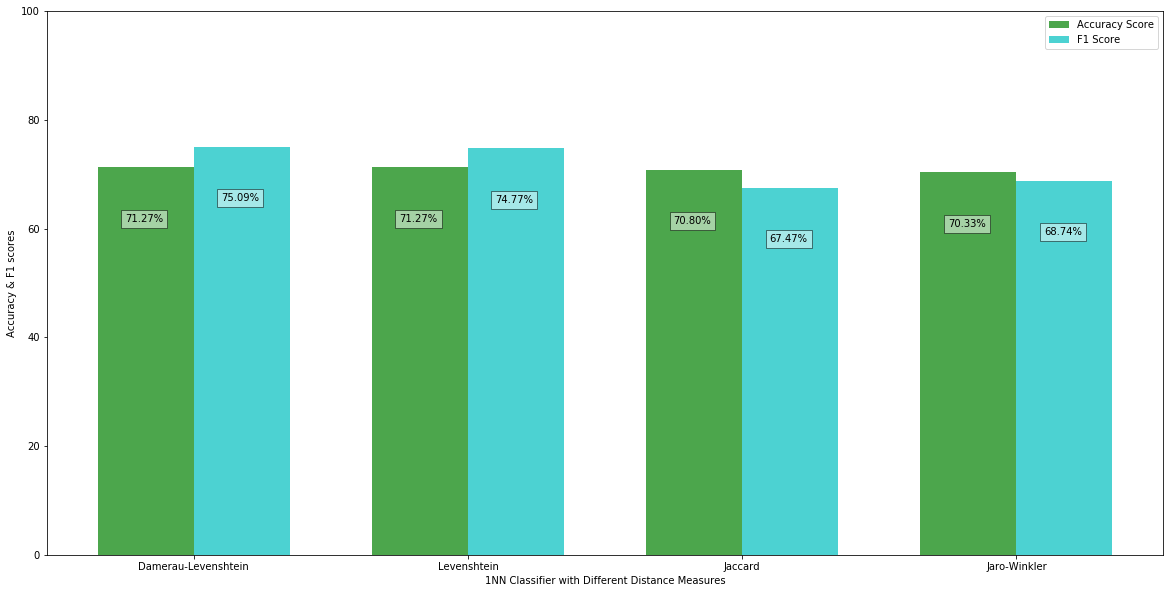

In [97]:
# plottiamo le accuracy a confronto

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

accuracy = ax.bar(index, [y[0] for y in distance_metrics], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Accuracy Score')
f1 = ax.bar(index + bar_width, [y[1] for y in distance_metrics], bar_width, alpha=opacity, color='c', error_kw=error_config, label='F1 Score')
labels = ['Damerau-Levenshtein', 'Levenshtein', 'Jaccard', 'Jaro-Winkler']
for acc, ff in zip(accuracy, f1):
    yval_acc = acc.get_height()
    yval_ff = ff.get_height()
    plt.text(acc.get_x() + 0.1, yval_acc - 10, '{:.2f}%'.format(round(yval_acc, 4)), bbox=dict(facecolor='white', alpha=0.5))
    plt.text(ff.get_x() + 0.1, yval_ff - 10, '{:.2f}%'.format(round(yval_ff, 4)), bbox=dict(facecolor='white', alpha=0.5))

ax.set_ylim(0, 100)
ax.set_xlabel('1NN Classifier with Different Distance Measures')
ax.set_ylabel('Accuracy & F1 scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()